$$ R_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k R_{t+k+1} $$

$$ L = \left( R_t + \gamma^n \max_{a'} Q(S_{t+n}, a') - Q(S_t, A_t) \right)^2 $$


In [1]:
import gymnasium as gym
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from Algorithms.Agents.BaseAgent import BaseAgent
from tqdm.notebook import tqdm


class NstepAgent(BaseAgent):
    def __init__(self, _env: gym.envs, use_conv=True, _lr=3e-4, _gamma=0.99, _buffer_size=10000, _nsteps=3):
        super().__init__(_env, use_conv, _lr, _gamma, _buffer_size)
        self.nsteps, self.nstep_buffer = _nsteps, []
        self.learn_start = 100 # todo maybe make them attrs of the BaseAgent
        self.update_freq = 1
        
    def append_to_replay(self, s, a, r, s_, te, tr):
        self.nstep_buffer.append((s,a,r,s_))
        if len(self.nstep_buffer) < self.nsteps:
            return
        
        R = sum([self.nstep_buffer[i][2] * (self.gamma ** i) for i in range(self.nsteps)])
        _state, _action, _, _ = self.nstep_buffer.pop(0)
        
        self.replay_buffer.push(_state, _action, R, s_, te, tr)
        
    def update(self, s ,a , r, s_, te, tr):
        self.frame += 1
        self.append_to_replay( s ,a , r, s_, te, tr)
        # todo add clip -1, 1, add learn_start frame
        
        if self.frame < self.learn_start or self.frame % self.update_freq != 0:
            return None
        _batch = self.replay_buffer.sample(self.batch_size)
        _loss = self.compute_loss(_batch)

        self.optimizer.zero_grad()
        _loss.backward()
        self.optimizer.step()
        
        return _loss
        
    def finish_nstep(self):
        while len(self.nstep_buffer) > 0:
            R = sum([self.nstep_buffer[i][2]*(self.gamma**i) for i in range(len(self.nstep_buffer))])
            _state, _action, _, _ = self.nstep_buffer.pop(0)

            self.replay_buffer.push((_state, _action, R, None))

In [4]:
env = gym.make('CartPole-v1')

episode_reward = 0
batch_size = 32
max_episodes = 400
max_steps = 1000

# Initialize your DQN model
agent = NstepAgent(env, use_conv=False)

episode_rewards, episode_losses = [], []
best_reward, best_model_path = -float('inf'), 'best_model.pth'

for episode in tqdm(range(max_episodes), desc='Training'):
    episode_reward, episode_loss = 0, 0
    state = env.reset()[0]
    state = th.tensor(state, dtype=th.float32).to(agent.device)

    for step in range(max_steps):
        action = agent.get_action(state)
        next_state, reward, term, trunc, _ = env.step(action)
        next_state = th.tensor(next_state, dtype=th.float32).to(agent.device)
        agent.replay_buffer.push(state, action, reward, next_state, term, trunc)

        episode_reward += reward

        loss = agent.update(state, action, reward, next_state, term, trunc)

        if loss is not None: episode_loss += loss.item()
            
        if term or trunc:
            episode_rewards.append(episode_reward)
            episode_losses.append(episode_loss)
            if episode % 100 == 0: print(f"Episode {episode}: rew->{episode_reward}\t")
            break
            
        if episode_reward > best_reward:
            best_reward = episode_reward
            th.save(agent.net.state_dict(), best_model_path)

        state = next_state

/home/kostiskak/anaconda3/envs/ai_env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Episode 0: rew->17.0	
Episode 100: rew->500.0	
Episode 200: rew->163.0	
Episode 300: rew->500.0	


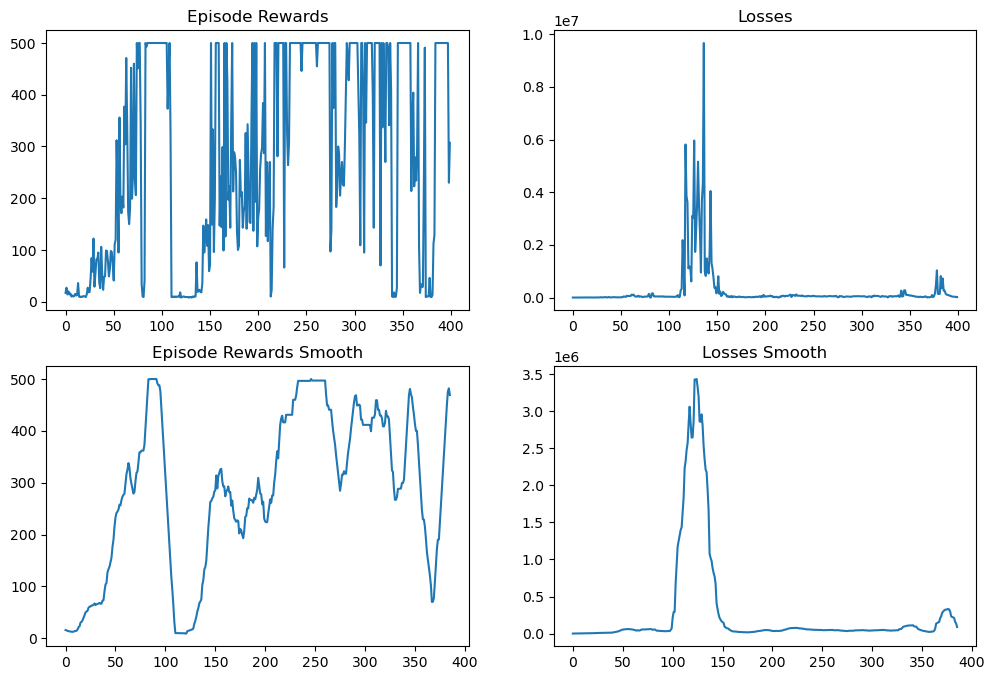

In [6]:
mv_avg = lambda arr, win: np.convolve(arr, np.ones(win)/win, mode='valid')
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(mv_avg(episode_rewards, 1))
plt.title("Episode Rewards")
plt.subplot(2, 2, 2)
plt.plot(mv_avg(episode_losses, 1))
plt.title("Losses")
plt.subplot(2, 2, 3)
plt.plot(mv_avg(episode_rewards, 15))
plt.title("Episode Rewards Smooth")
plt.subplot(2, 2, 4)
plt.plot(mv_avg(episode_losses, 15))
plt.title("Losses Smooth")

plt.show()


### Plot conclusions: 
We can see two things:
1. Whenever the reward is small (either in the beginning or in the explanation stage) the loss is higher, meaning that the network is learning.
2. Even when the reward is high the loss is non-zero, because even if the max reward is achieved the network is still learning.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a trained DQN model `agent.model`
# and you know the ranges for each state variable in CartPole
env = gym.make('CartPole-v1')
state = th.tensor(env.reset()[0], dtype=th.float32).to(agent.device)
agent = NstepAgent(env, use_conv=False)

# Sample states (example for position and velocity)
positions = np.linspace(-4.8, 4.8, 100)  # Adjust as per actual range
velocities = np.linspace(-50, 50, 100)  # Adjust as per actual range
actions = [0, 1]  # Possible actions in CartPole



best_model = BaseAgent(env, use_conv=False, _model_path=best_model_path, eval_mode=True)
best_model.load()
best_model.net(state)


for pos in positions:
    for vel in velocities:
        state = np.array([pos, 0, vel, 0])  # Example state
        state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0).to('cuda')
        q_values = agent.net(state_tensor).detach().cpu().numpy().flatten()
        
        # Plotting
        plt.plot(actions, q_values, label=f'Pos: {pos}, Vel: {vel}')

plt.xlabel('Actions')
plt.ylabel('Q-values')
plt.legend()
plt.show()


NameError: name 'agent' is not defined

# Load the best model has failed

In [8]:
env = gym.make('CartPole-v1')
agent = BaseAgent(env, use_conv=False, eval_mode=True)
state = th.tensor(env.reset()[0], dtype=th.float32).to(agent.device)
agent.load()
agent.net(state)

episode_reward = 0
batch_size = 32
max_episodes = 400
max_steps = 1000

episode_rewards, episode_losses = [], []
best_reward, best_model_path = -float('inf'), 'best_model.pth'

for episode in tqdm(range(max_episodes), desc='Testing'):
    episode_reward, episode_loss = 0, 0
    state = env.reset()[0]
    state = th.tensor(state, dtype=th.float32).to(agent.device)

    for step in range(max_steps):
        action = agent.get_action(state)
        next_state, reward, term, trunc, _ = env.step(action)
        next_state = th.tensor(next_state, dtype=th.float32).to(agent.device)
        agent.replay_buffer.push(state, action, reward, next_state, term, trunc)

        episode_reward += reward

        loss = agent.update(state, action, reward, next_state, term, trunc)

        if loss is not None: episode_loss += loss.item()
            
        if term or trunc:
            episode_rewards.append(episode_reward)
            episode_losses.append(episode_loss)
            if episode % 100 == 0: print(f"Episode {episode}: rew->{episode_reward}\t")
            break
            
        if episode_reward > best_reward:
            best_reward = episode_reward
            th.save(agent.net.state_dict(), best_model_path)

        state = next_state

/home/kostiskak/anaconda3/envs/ai_env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Episode 0: rew->500.0	
Episode 100: rew->8.0	
Episode 200: rew->180.0	
Episode 300: rew->8.0	


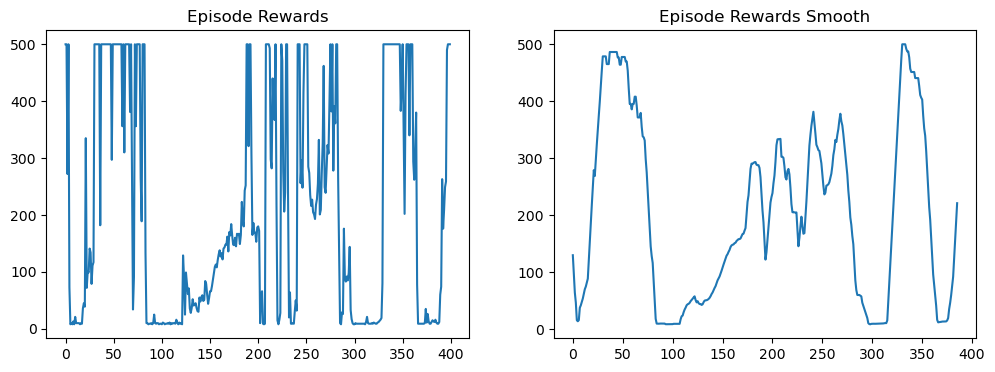

In [10]:
mv_avg = lambda arr, win: np.convolve(arr, np.ones(win)/win, mode='valid')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mv_avg(episode_rewards, 1))
plt.title("Episode Rewards")
plt.subplot(1, 2, 2)
plt.plot(mv_avg(episode_rewards, 15))
plt.title("Episode Rewards Smooth")

plt.show()


The analysis indicates that although the model is not flawless, it has indeed learned effectively, often achieving perfect scores in several instances. 
This suggests a notable level of proficiency in its performance.

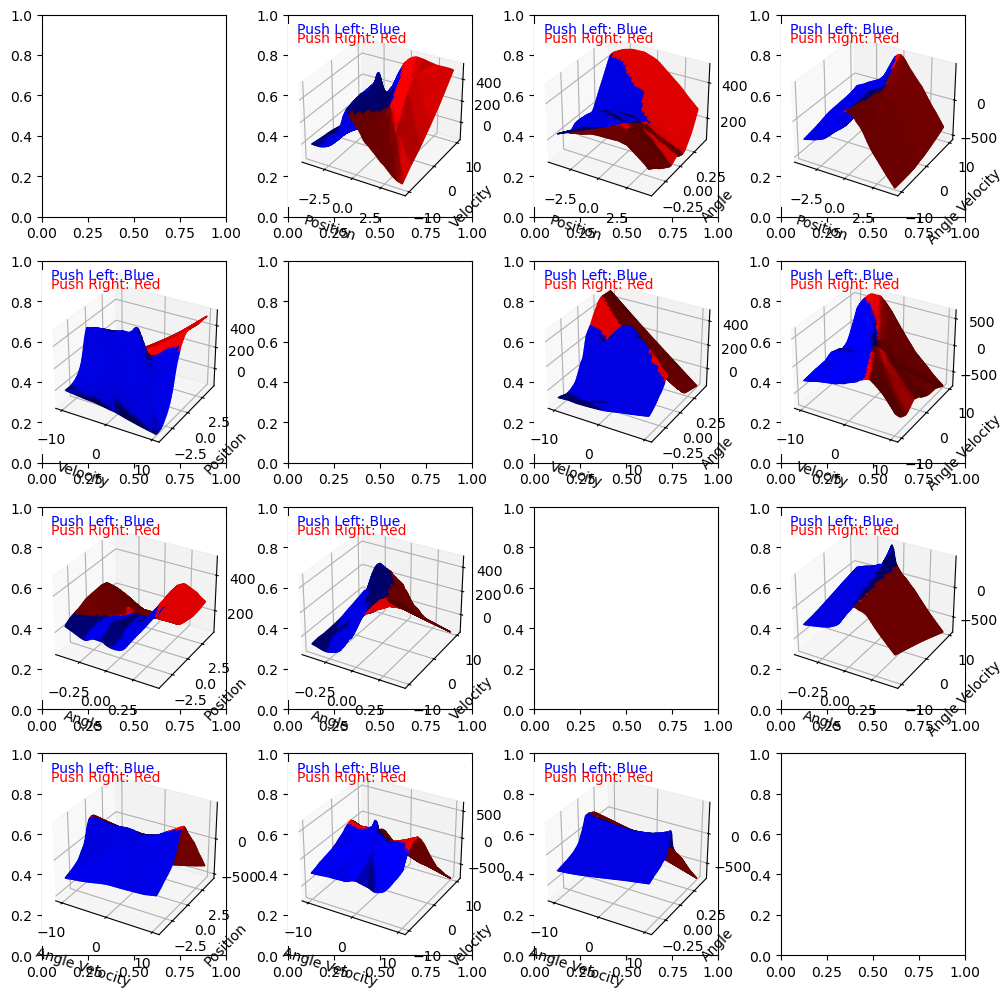

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th

def plot_variable_pairs(var1, var2, var1_values, var2_values, agent, subplot):
    for val1 in var1_values:
        for val2 in var2_values:
            state = np.zeros(4)
            state[var1] = val1
            state[var2] = val2
            state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0).to('cuda')
            q_values = agent.net(state_tensor).detach().cpu().numpy().flatten()
            subplot.plot([0, 1], q_values, label=f'{var1_names[var1]}: {val1}, {var1_names[var2]}: {val2}')
            
def plot_variable_pairs_3d(var1, var2, var1_values, var2_values, agent, subplot):
    X, Y = np.meshgrid(var1_values, var2_values)
    Z_action_0 = np.zeros_like(X)
    Z_action_1 = np.zeros_like(X)

    for i, val1 in enumerate(var1_values):
        for j, val2 in enumerate(var2_values):
            state = np.zeros(4)
            state[var1] = val1
            state[var2] = val2
            state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0).to('cuda')
            q_values = agent.net(state_tensor).detach().cpu().numpy()
            Z_action_0[i, j] = q_values[0][0]
            Z_action_1[i, j] = q_values[0][1]

    # Plot for action 0
    subplot.plot_surface(X, Y, Z_action_0, cmap='Blues', label='push left')

    # Plot for action 1
    subplot.plot_surface(X, Y, Z_action_1, cmap='Oranges', label='push right')

    # Annotations or Custom Legend
    subplot.text2D(0.05, 0.95, "push left", transform=subplot.transAxes, color='blue')
    subplot.text2D(0.05, 0.90, "push right", transform=subplot.transAxes, color='orange')


    subplot.legend()
    
def plot_max_q_surface(var1, var2, var1_values, var2_values, agent, subplot):
    X, Y = np.meshgrid(var1_values, var2_values)
    Z = np.zeros_like(X)
    Colors = np.zeros(X.shape + (4,))  # RGBA colors

    for i, val1 in enumerate(var1_values):
        for j, val2 in enumerate(var2_values):
            state = np.zeros(4)
            state[var1] = val1
            state[var2] = val2
            state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0).to('cuda')
            q_values = agent.net(state_tensor).detach().cpu().numpy()[0]

            max_q_index = np.argmax(q_values)
            Z[i, j] = q_values[max_q_index]
            if max_q_index == 0:
                Colors[i, j] = [0, 0, 1, 1]  # Blue for action 0
            else:
                Colors[i, j] = [1, 0, 0, 1]  # Red for action 1

    subplot.plot_surface(X, Y, Z, facecolors=Colors, label='Max Q-value Action')
    
    # Annotations for action-color mapping
    subplot.text2D(0.05, 0.95, "Push Left: Blue", transform=subplot.transAxes, color='blue')
    subplot.text2D(0.05, 0.90, "Push Right: Red", transform=subplot.transAxes, color='red')


# Plot creation logic remains the same as before


# Define the observation space variables
positions = np.linspace(-4, 4, 100)
velocities = np.linspace(-10, 10, 100)
angles = np.linspace(-0.418, 0.418, 100)
angle_velocities = np.linspace(-10, 10, 100)

var_arrays = {
    "Position": positions,
    "Velocity": velocities,
    "Angle": angles,
    "Angle Velocity": angle_velocities
}

# Variable names for labeling
var1_names = ["Position", "Velocity", "Angle", "Angle Velocity"]

# Create subplots for each combination
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    for j in range(4):
        if i != j:
            ax = fig.add_subplot(4, 4, i * 4 + j + 1, projection='3d')
            var1_array = var_arrays[var1_names[i]]
            var2_array = var_arrays[var1_names[j]]
            plot_max_q_surface(i, j, var1_array, var2_array, agent, ax)
            ax.set_xlabel(var1_names[i])
            ax.set_ylabel(var1_names[j])
        else:
            ax = fig.add_subplot(4, 4, i * 4 + j + 1)
            ax.axis('off')

plt.tight_layout()
plt.show()


From the plots here we can see that the model as already learned some patterns in the observation spacer that will produce with Q values meaning good results:

Some obvious ones are that:
1. The angle velocity doesn't correlate with all the others that much. the decisions in this case are mostly according to the sign of the others.
2. The same thing seems to happen with positional velocity. Where positional velocity doesn't seem to affect the action taken when the comparison happens between all the others.
3. A more complex rule seems to have been extracted in the case of position with the angle where they seem to be highly correlated with respect to the Q value. The decision boundary seems to be something like: 
	push left if pos < -5*|angle| else push right

So the Rules seem to be simple and quite like a simple positional controller, since the velocities don't seem to affect the decision taken that much.